The notebook merges the DEM tiles downloaded from Kortforsyning, downsamples the resolution to 2m, crops the resulted DEM to the area of interest and masks the water. 

Importing the relevant libraries

In [ ]:
from osgeo import gdal
import os
import glob
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio.mask
import numpy as np
import geopandas as gpd


Setting the directory

In [ ]:
os.chdir('/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DTM_raw')

Showing the list of the files in the directory that start with "DTM_1km_*" and are in .tif format

In [ ]:
demList = glob.glob('DTM_1km_*.tif')

Building a virtual raster layer with GDAL, setting the resolution to 2m and saving it

In [ ]:
vrt = gdal.BuildVRT("merged.vrt", demList)
gdal.Translate("/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/DTM_2m.tif", vrt, xRes = 2, yRes = -2)
vrt = None

Opening the resulted file

In [ ]:
dem = gdal.Open('/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/DTM_2m.tif')
dem

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f829b09e4b0> >

Checking its projection

In [ ]:
dem.GetProjection()

'PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25832"]]'

Cropping it to the area of interest with a shapefile produced in ArcGIS as an AOI polygon

In [ ]:
# clip 
# make sure your raster data and shapefile have the same projection!
demClip = gdal.Warp("/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/dem2m_ROI.tif", dem, cutlineDSName = "/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/ROI/ROI_shp/ROI.shp",
                   cropToCutline = True, dstNodata = np.nan)

In [ ]:
# close your datasets!
dem = demClip = None

Plotting the area of interest (AOI)

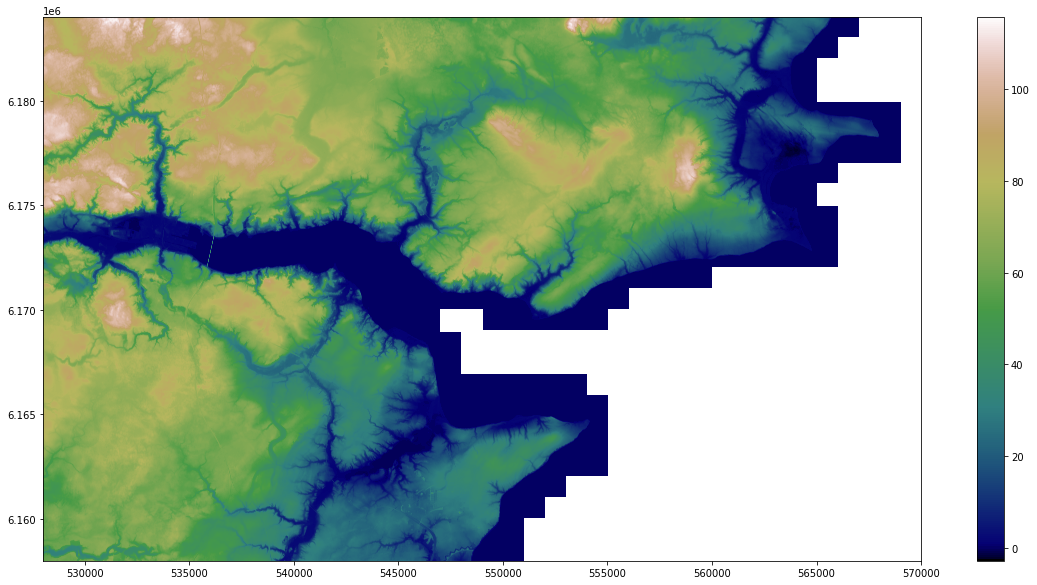

In [ ]:
from matplotlib import colors, cm
src = rasterio.open("/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/dem_ROI.tif")
fig, ax = plt.subplots(figsize=(20, 10))
cmap = plt.get_cmap('gist_earth')
data = src.read()
show(data, transform=src.transform, ax=ax, cmap=cmap)
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data)), cmap=cmap), ax=ax)
plt.savefig('/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/DEM_ROI.png')

Cropping the raster to the land polygon to remove cells representing water

Opening a land mask polygon

In [ ]:
land_mask=gpd.read_file('/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/land_mask/land_mask.shp')

Checking its type

In [ ]:
land_mask.type

0    Polygon
dtype: object

Checking its boundary

In [ ]:
land_mask.bounds

,minx,miny,maxx,maxy
0,528000.0,6158000.0,567952.0,6184000.0


Plotting for visualization

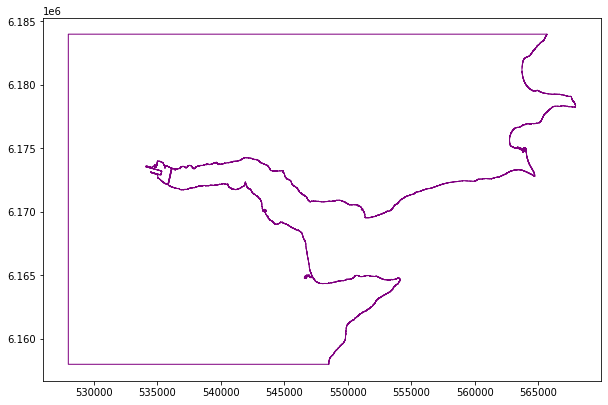

In [ ]:
land_mask.plot(figsize=(10,10), edgecolor="purple", facecolor="None")

Cropping the raster DEM with the land mask

In [ ]:
with rasterio.open('/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/dem_ROI.tif') as src:
    prj = src.crs.to_wkt()
    land_mask_reproj = land_mask.to_crs(prj)
    shapes = [land_mask_reproj['geometry'].values[0]]
    
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [ ]:
out_meta.update({"driver":"GTiff",
                "height": out_image.shape[1],"width":out_image.shape[2],
                "transform": out_transform})

with rasterio.open('/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/dem_land.tif', "w", **out_meta) as dest:
    dest.write(out_image)

Plotting the reslt for visual inspection and saving it as a figure

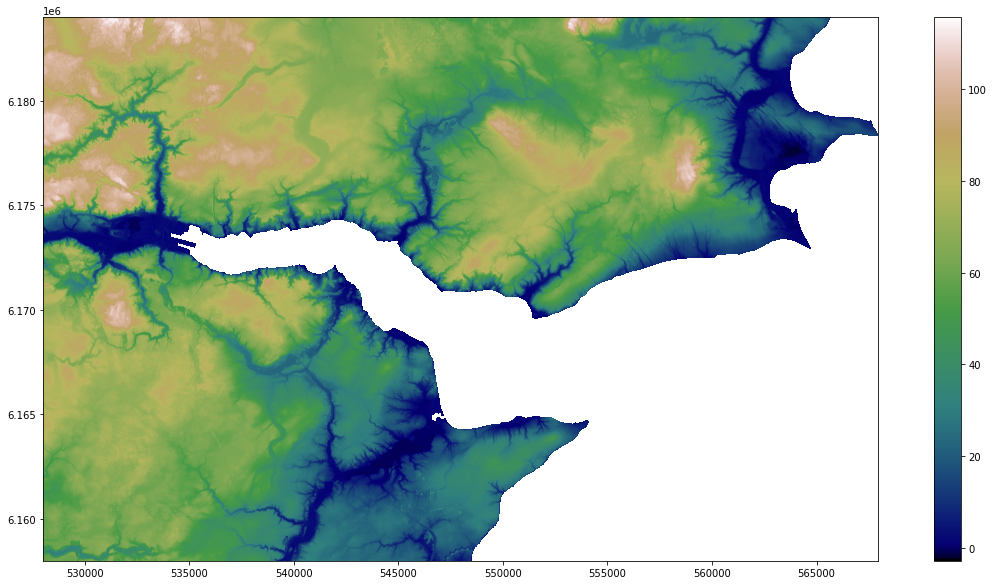

In [ ]:
from matplotlib import colors, cm
src = rasterio.open("/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/dem_land.tif")
fig, ax = plt.subplots(figsize=(20, 10))
cmap = plt.get_cmap('gist_earth')
data = src.read()
show(data, transform=src.transform, ax=ax, cmap=cmap)
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data)), cmap=cmap), ax=ax)
plt.savefig('/content/drive/MyDrive/P8/Data/Hojdemodel_Vejle/DEM_ROI/DEM_land.png')